# Global Spatial Autocorrelation


In [1]:
%matplotlib inline
import pysal as ps
import pandas as pd
import numpy as np
from pysal.contrib.viz import mapping as maps

A well-used functionality in PySAL is the use of PySAL to conduct exploratory spatial data analysis. This notebook will provide an overview of ways to conduct exploratory spatial analysis in Python. 

First, let's read in some data:

In [2]:
data = ps.pdio.read_files("data/texas.shp")

In [3]:
data.head()

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
0,Lipscomb,Texas,48,295,48295,48,295,48295,1,0.0,...,0.031817,0.286929,0.378219,0.407005,0.373005,6.724512,4.5,3.835360,6.093580,<pysal.cg.shapes.Polygon object at 0x10f9b01d0>
1,Sherman,Texas,48,421,48421,48,421,48421,1,0.0,...,0.139958,0.288976,0.359377,0.415453,0.378041,5.665722,1.7,3.253796,3.869407,<pysal.cg.shapes.Polygon object at 0x10f9b0250>
2,Dallam,Texas,48,111,48111,48,111,48111,1,0.0,...,2.050906,0.331667,0.385996,0.370037,0.376015,7.546049,7.2,9.471366,14.231738,<pysal.cg.shapes.Polygon object at 0x10f9b02d0>
3,Hansford,Texas,48,195,48195,48,195,48195,1,0.0,...,0.000000,0.253527,0.357813,0.393938,0.383924,7.591786,4.7,5.542986,7.125457,<pysal.cg.shapes.Polygon object at 0x10f9b0350>
4,Ochiltree,Texas,48,357,48357,48,357,48357,1,0.0,...,0.021911,0.236998,0.352940,0.343949,0.374461,5.172414,4.0,4.758392,9.159159,<pysal.cg.shapes.Polygon object at 0x10f9b03d0>


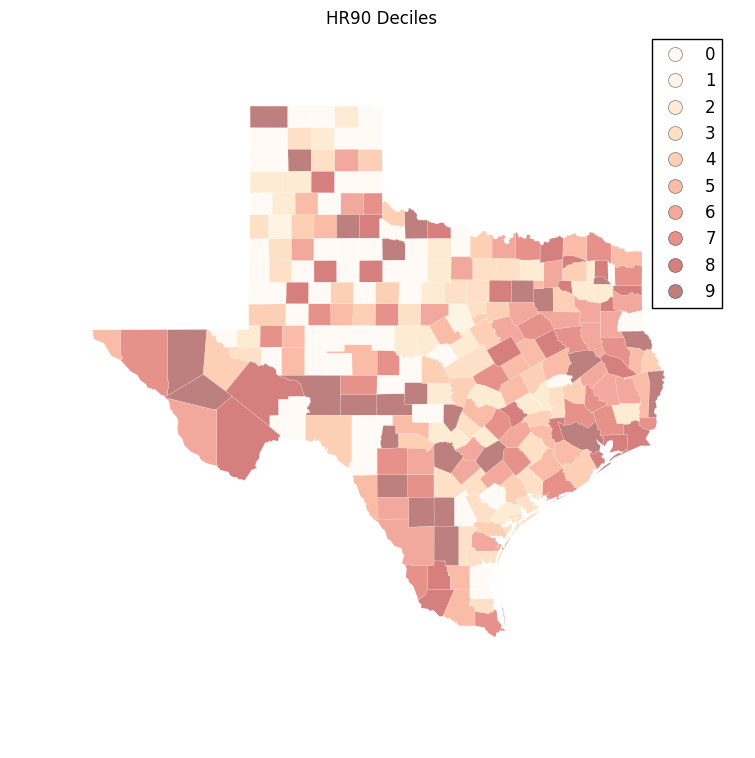

In [4]:
import matplotlib.pyplot as plt

import geopandas as gpd
shp_link = "data/texas.shp"
tx = gpd.read_file(shp_link)
hr10 = ps.Quantiles(data.HR90, k=10)
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=hr10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("HR90 Deciles")
plt.show()

## Spatial Autocorrelation

Visual inspection of the map pattern for HR90 deciles allows us to search for spatial structure. If the spatial distribution of the rates was random, then we should not see any clustering of similar values on the map. However, our visual system is drawn to the darker clusters in the south west as well as the east, and a concentration of the lighter hues (lower homicide rates) moving north to the pan handle.

Our brains are very powerful pattern recognition machines. However, sometimes they can be too powerful and lead us to detect false positives, or patterns where there are no statistical patterns. This is a particular concern when dealing with visualization of irregular polygons of differning sizes and shapes.

The concept of *spatial autocorrelation* relates to the combination of two types of similarity: spatial similarity and attribute similarity. Although there are many different measures of spatial autocorrelation, they all combine these two types of simmilarity into a summary measure.

Let's use PySAL to generate these two types of similarity measures.

### Spatial Similarity

We have already encountered spatial weights in a previous notebook. In spatial autocorrelation analysis, the spatial weights are used to formalize the notion of spatial similarity. As we have seen there are many ways to define spatial weights, here we will use queen contiguity:

In [5]:

data = ps.pdio.read_files("data/texas.shp")
W = ps.queen_from_shapefile("data/texas.shp")
W.transform = 'r'

### Attribute Similarity

So the spatial weight between counties $i$ and $j$ indicates if the two counties are neighbors (i.e., geographically similar). What we also need is a measure of attribute similarity to pair up with this concept of spatial similarity.
The **spatial lag** is a derived variable that accomplishes this for us. For county $i$ the spatial lag is defined as:
$$HR90Lag_i = \sum_j w_{i,j} HR90_j$$



In [6]:
HR90Lag = ps.lag_spatial(W, data.HR90)

In [7]:
HR90LagQ10 = ps.Quantiles(HR90Lag, k=10)

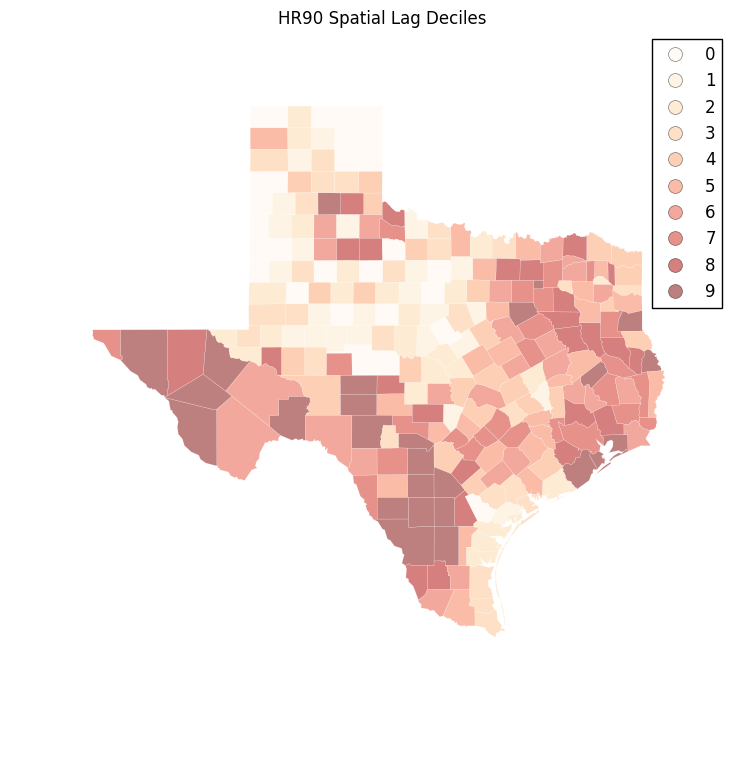

In [8]:
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=HR90LagQ10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("HR90 Spatial Lag Deciles")

plt.show()

The decile map for the spatial lag tends to enhance the impression of value similarity in space. However, we still have the challenge of visually associating the value of the homicide rate in a county with the value of the spatial lag of rates for the county. The latter is a weighted average of homicide rates in the focal county's neighborhood.

To complement the geovisualization of these associations we can turn to formal statistical measures of spatial autocorrelation.

In [9]:
HR90 = data.HR90
b,a = np.polyfit(HR90, HR90Lag, 1)

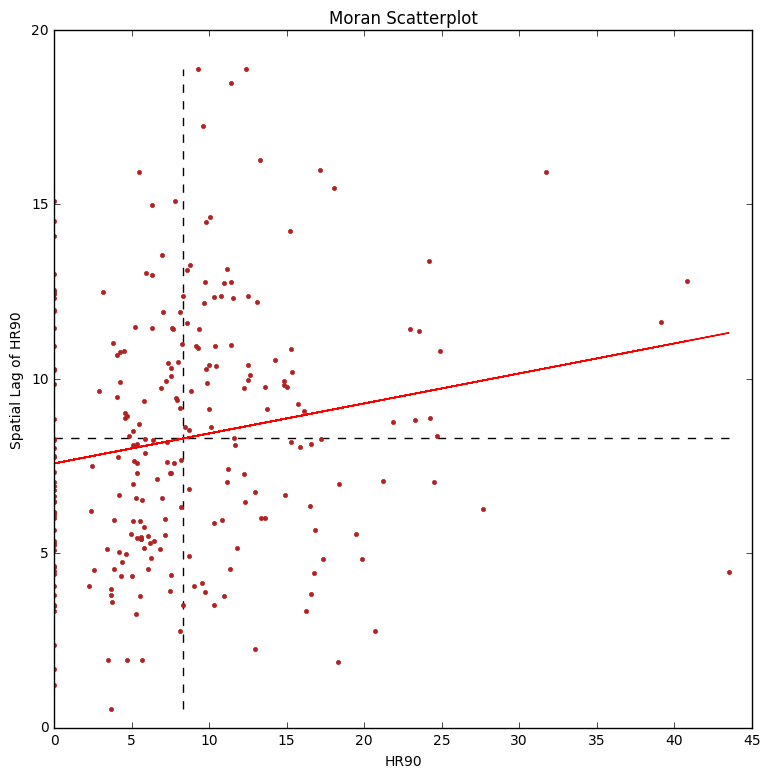

In [10]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(HR90, HR90Lag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(HR90.mean(), HR90Lag.min(), HR90Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(HR90Lag.mean(), HR90.min(), HR90.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(HR90, a + b*HR90, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HR90')
plt.xlabel('HR90')
plt.show()

## Global Spatial Autocorrelation

In PySAL, commonly-used analysis methods are very easy to access. For example, if we were interested in examining the spatial dependence in `HR90` we could quickly compute a Moran's $I$ statistic:

In [11]:
I_HR90 = ps.Moran(data.HR90.values, W)

In [12]:
I_HR90.I, I_HR90.p_sim

(0.085976640313889768, 0.0080000000000000002)

Thus, the $I$ statistic is $0.859$ for this data, and has a very small $p$ value. 

In [13]:
b # note I is same as the slope of the line in the scatterplot

0.085976640313889754

We can visualize the distribution of simulated $I$ statistics using the stored collection of simulated statistics:

In [14]:
I_HR90.sim[0:5]

array([-0.07725199, -0.04078806, -0.02019627, -0.00666591, -0.01065527])

A simple way to visualize this distribution is to make a KDEplot (like we've done before), and add a rug showing all of the simulated points, and a vertical line denoting the observed value of the statistic:

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

(-0.15, 0.15)

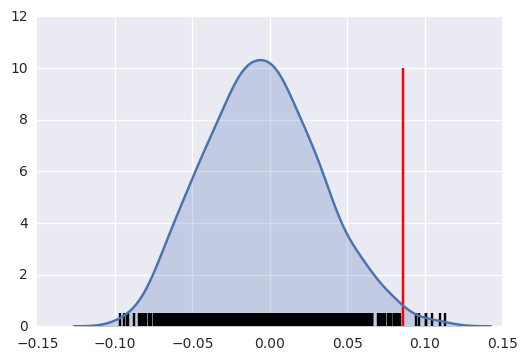

In [16]:
sns.kdeplot(I_HR90.sim, shade=True)
plt.vlines(I_HR90.sim, 0, 0.5)
plt.vlines(I_HR90.I, 0, 10, 'r')
plt.xlim([-0.15, 0.15])

Instead, if our $I$ statistic were close to our expected value, `I_HR90.EI`, our plot might look like this:

(-0.15, 0.15)

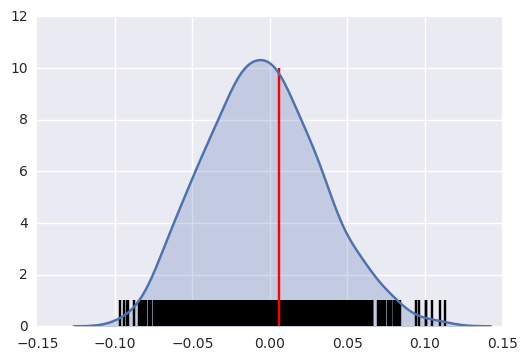

In [17]:
sns.kdeplot(I_HR90.sim, shade=True)
plt.vlines(I_HR90.sim, 0, 1)
plt.vlines(I_HR90.EI+.01, 0, 10, 'r')
plt.xlim([-0.15, 0.15])

The result of applying Moran's I is that we conclude the map pattern is not spatially random, but instead there is a signficant spatial association in homicide rates in Texas counties in 1990.

This result applies to the map as a whole, and is sometimes referred to as "global spatial autocorrelation". Later we turn to a local analysis where the attention shifts to detection of hot spots, cold spots and spatial outliers.

## Exercises

1. Repeat the global analysis for the years 1960, 70, 80 and compare the results to what we found in 1990.


## Solutions

In [48]:
np.random.seed(12345)
I_pv = [ps.Moran(data[var].values, W).p_sim for var in ['HR60', 'HR70', 'HR80', 'HR90']]
I_pv

[0.121, 0.002, 0.001, 0.016]